In [1]:
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import hub
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchaudio

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score, recall_score, precision_score, balanced_accuracy_score, accuracy_score, classification_report
from sklearn.utils import shuffle

import scipy

from tqdm import tqdm

from datasets import load_dataset, Dataset, Audio
import librosa
from transformers import AutoFeatureExtractor, Wav2Vec2ForSequenceClassification

from models.basic_transformer import BasicTransformer

from src.utils import AphasiaDatasetMFCC, AphasiaDatasetSpectrogram, AphasiaDatasetWaveform

from collections import Counter

2025-03-15 23:34:38.593481: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-15 23:34:38.704442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742070878.749374 1312974 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742070878.762195 1312974 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-15 23:34:38.853343: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
AUDIO_LENGTH = 6_000
SEQUENCE_LENGTH = 31
MFCC = 128
print(f"It's {DEVICE} time!!!")

It's cuda time!!!


In [3]:
DATA_DIR = os.path.join('..', 'data')
VOICES_DIR = os.path.join(DATA_DIR, 'Voices')
APHASIA_DIR = os.path.join(VOICES_DIR, 'Aphasia')
NORM_DIR = os.path.join(VOICES_DIR, 'Norm')

In [4]:
train_dataset = AphasiaDatasetWaveform(os.path.join(DATA_DIR, "train_filenames.csv"), VOICES_DIR, target_sample_rate=8_000)
test_dataset = AphasiaDatasetWaveform(os.path.join(DATA_DIR, "val_filenames.csv"), VOICES_DIR, target_sample_rate=8_000)
val_dataset = AphasiaDatasetWaveform(os.path.join(DATA_DIR, "test_filenames.csv"), VOICES_DIR, target_sample_rate=8_000)

 # Class balancing for train
train_labels = [label for _, label in train_dataset.data]
class_counts = Counter(train_labels)
if len(class_counts) < 2:
    raise ValueError("One of the classes is missing in the training set")


class_weights = {label: 1.0 / count for label, count in class_counts.items()}
weights = [class_weights[label] for _, label in train_dataset.data]
train_sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset), replacement=True)


In [5]:
MAX_LEN = 120_000

In [6]:
def pad_sequence(batch):
    if not batch:
        return torch.zeros(0), torch.zeros(0)
    
    seq, labels = zip(*batch)
    max_len = max(s.shape[1] for s in seq)
    padded = torch.zeros(len(seq), MAX_LEN)
    for i, s in enumerate(seq):
        padded[i, :s.shape[1]] = s[0, :MAX_LEN]
    
    return padded, torch.stack(labels) 

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler, collate_fn=pad_sequence, drop_last=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=pad_sequence, drop_last=True, num_workers=6)

In [8]:
class Wav2vecClassifier(nn.Module):
    
    def __init__(self, num_labels: int=2, unfreeze: float=0.5):
        super(Wav2vecClassifier, self).__init__()
        
        self.wav2vec = Wav2Vec2ForSequenceClassification.from_pretrained(
                            "facebook/wav2vec2-base",
                            num_labels=num_labels,
                        )
        self.num_parameters = len(list(self.wav2vec.parameters()))
        for ind, param in enumerate(self.wav2vec.parameters()):
            
            if ind + 4 < int(self.num_parameters * unfreeze):
                param.requires_grad = False
            else:
                param.requires_grad = True
                
    def forward(self, audio):
        return self.wav2vec(audio)

In [9]:
def train_model(model, dl_train, dl_val, epochs=1, lr=0.001, device="cpu"):
      
    model = model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
        
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, threshold=1e-3)

    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    for epoch in tqdm(range(epochs), desc="Training model"):
        model.train()
        total_train_loss = 0
        total_val_loss = 0
        
        train_acc = []
        val_acc = []
        for features, target in dl_train:
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            
            output = model(features).logits
            preds = torch.argmax(output, dim=1).cpu().detach().numpy()
            train_acc.append(accuracy_score(target.cpu().detach().numpy(), preds))
            
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.detach().item()
        
        avg_train_acc = np.stack(train_acc, axis=0).mean()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
                
        model.eval()
        
        with torch.no_grad():
            for features, target in dl_val:
                features, target = features.to(device), target.to(device)
                
                output = model(features).logits
                
                preds = torch.argmax(output, dim=1).cpu().detach().numpy()
                val_acc.append(accuracy_score(target.cpu().detach().numpy(), preds))
                loss = criterion(output, target)
                total_val_loss += loss.detach().item()
        
        avg_val_acc = np.stack(val_acc, axis=0).mean()
        avg_val_loss = total_val_loss / len(dl_val)
        val_loss_list.append(avg_val_loss)
        val_acc_list.append(avg_val_acc)
        
        if scheduler:
            try:
                scheduler.step()
            except:
                scheduler.step(avg_val_loss)
        
        tqdm.write(f"Epoch {epoch}: train loss: {avg_train_loss:.3f}, train balanced acc: {avg_train_acc:.2f}, test loss: {avg_val_loss:.3f}, test balanced acc: {avg_val_acc:.2f}, lr: {optimizer.param_groups[0]['lr']}")

            
    return model, train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [10]:
wav2vec = Wav2vecClassifier(unfreeze=0.75)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from termcolor import colored
from collections import defaultdict

def beautiful_int(i):
    i = str(i)
    return ".".join(reversed([i[max(j, 0):j+3] for j in range(len(i) - 3, -3, -3)]))

# Calculate the total number of parameters in our model

def model_num_params(model, verbose_all=True, verbose_only_learnable=False):
    sum_params = 0
    sum_learnable_params = 0
    submodules = defaultdict(lambda : [0, 0])
    for name, param in model.named_parameters():
        num_params = np.prod(param.shape)
        if verbose_all or (verbose_only_learnable and param[1].requires_grad):
            print(
                colored(
                    '{: <42} ~  {: <9} params ~ grad: {}'.format(
                        name,
                        beautiful_int(num_params),
                        param.requires_grad,
                    ),
                    {True: "green", False: "red"}[param.requires_grad],
                )
            )
        sum_params += num_params
        sm = name.split(".")[0]
        submodules[sm][0] += num_params
        if param.requires_grad:
            sum_learnable_params += num_params
            submodules[sm][1] += num_params
    print(
        f'\nIn total:\n  - {beautiful_int(sum_params)} params\n  - {beautiful_int(sum_learnable_params)} learnable params'
    )

    for sm, v in submodules.items():
        print(
            f"\n . {sm}:\n .   - {beautiful_int(submodules[sm][0])} params\n .   - {beautiful_int(submodules[sm][1])} learnable params"
        )
    return sum_params, sum_learnable_params


sum_params, sum_learnable_params = model_num_params(wav2vec)

wav2vec.wav2vec2.masked_spec_embed         ~  768       params ~ grad: False
wav2vec.wav2vec2.feature_extractor.conv_layers.0.conv.weight ~  5.120     params ~ grad: False
wav2vec.wav2vec2.feature_extractor.conv_layers.0.layer_norm.weight ~  512       params ~ grad: False
wav2vec.wav2vec2.feature_extractor.conv_layers.0.layer_norm.bias ~  512       params ~ grad: False
wav2vec.wav2vec2.feature_extractor.conv_layers.1.conv.weight ~  786.432   params ~ grad: False
wav2vec.wav2vec2.feature_extractor.conv_layers.2.conv.weight ~  786.432   params ~ grad: False
wav2vec.wav2vec2.feature_extractor.conv_layers.3.conv.weight ~  786.432   params ~ grad: False
wav2vec.wav2vec2.feature_extractor.conv_layers.4.conv.weight ~  786.432   params ~ grad: False
wav2vec.wav2vec2.feature_extractor.conv_layers.5.conv.weight ~  524.288   params ~ grad: False
wav2vec.wav2vec2.feature_extractor.conv_layers.6.conv.weight ~  524.288   params ~ grad: False
wav2vec.wav2vec2.feature_projection.layer_norm.weight ~  5

In [12]:
wav2vec, train_l, val_l, train_acc, val_acc = train_model(wav2vec, train_dataloader, val_dataloader, epochs=30, lr=0.001, device=DEVICE)

Training model:   3%|▎         | 1/30 [02:52<1:23:21, 172.46s/it]

Epoch 0: train loss: 0.702, train balanced acc: 0.50, test loss: 0.681, test balanced acc: 0.85, lr: 0.001


Training model:   7%|▋         | 2/30 [05:52<1:22:38, 177.07s/it]

Epoch 1: train loss: 0.694, train balanced acc: 0.49, test loss: 0.693, test balanced acc: 0.15, lr: 0.001


Training model:  10%|█         | 3/30 [08:55<1:20:46, 179.51s/it]

Epoch 2: train loss: 0.693, train balanced acc: 0.51, test loss: 0.703, test balanced acc: 0.15, lr: 0.001


Training model:  13%|█▎        | 4/30 [12:00<1:18:46, 181.80s/it]

Epoch 3: train loss: 0.694, train balanced acc: 0.49, test loss: 0.660, test balanced acc: 0.85, lr: 0.001


Training model:  17%|█▋        | 5/30 [15:06<1:16:20, 183.22s/it]

Epoch 4: train loss: 0.694, train balanced acc: 0.49, test loss: 0.698, test balanced acc: 0.15, lr: 0.001


Training model:  20%|██        | 6/30 [18:13<1:13:47, 184.49s/it]

Epoch 5: train loss: 0.694, train balanced acc: 0.49, test loss: 0.696, test balanced acc: 0.15, lr: 0.001


Training model:  23%|██▎       | 7/30 [21:21<1:11:08, 185.60s/it]

Epoch 6: train loss: 0.694, train balanced acc: 0.49, test loss: 0.686, test balanced acc: 0.85, lr: 0.0005


Training model:  27%|██▋       | 8/30 [24:27<1:08:11, 185.97s/it]

Epoch 7: train loss: 0.693, train balanced acc: 0.50, test loss: 0.683, test balanced acc: 0.85, lr: 0.0005


Training model:  30%|███       | 9/30 [27:35<1:05:17, 186.55s/it]

Epoch 8: train loss: 0.693, train balanced acc: 0.51, test loss: 0.685, test balanced acc: 0.85, lr: 0.0005


Training model:  33%|███▎      | 10/30 [30:41<1:02:06, 186.31s/it]

Epoch 9: train loss: 0.693, train balanced acc: 0.49, test loss: 0.689, test balanced acc: 0.85, lr: 0.00025


Training model:  37%|███▋      | 11/30 [33:44<58:42, 185.40s/it]  

Epoch 10: train loss: 0.693, train balanced acc: 0.50, test loss: 0.690, test balanced acc: 0.85, lr: 0.00025


Training model:  40%|████      | 12/30 [36:49<55:32, 185.11s/it]

Epoch 11: train loss: 0.693, train balanced acc: 0.50, test loss: 0.691, test balanced acc: 0.85, lr: 0.00025


Training model:  43%|████▎     | 13/30 [39:53<52:24, 185.00s/it]

Epoch 12: train loss: 0.693, train balanced acc: 0.52, test loss: 0.688, test balanced acc: 0.85, lr: 0.000125


Training model:  47%|████▋     | 14/30 [43:03<49:40, 186.28s/it]

Epoch 13: train loss: 0.693, train balanced acc: 0.50, test loss: 0.689, test balanced acc: 0.85, lr: 0.000125


Training model:  50%|█████     | 15/30 [46:11<46:44, 186.95s/it]

Epoch 14: train loss: 0.693, train balanced acc: 0.49, test loss: 0.690, test balanced acc: 0.85, lr: 0.000125


Training model:  53%|█████▎    | 16/30 [49:20<43:46, 187.57s/it]

Epoch 15: train loss: 0.693, train balanced acc: 0.51, test loss: 0.689, test balanced acc: 0.85, lr: 6.25e-05


Training model:  57%|█████▋    | 17/30 [52:35<41:05, 189.68s/it]

Epoch 16: train loss: 0.693, train balanced acc: 0.50, test loss: 0.690, test balanced acc: 0.85, lr: 6.25e-05


Training model:  60%|██████    | 18/30 [55:38<37:33, 187.79s/it]

Epoch 17: train loss: 0.693, train balanced acc: 0.50, test loss: 0.690, test balanced acc: 0.85, lr: 6.25e-05


Training model:  63%|██████▎   | 19/30 [58:43<34:14, 186.78s/it]

Epoch 18: train loss: 0.693, train balanced acc: 0.49, test loss: 0.692, test balanced acc: 0.85, lr: 3.125e-05


Training model:  67%|██████▋   | 20/30 [1:01:47<31:00, 186.07s/it]

Epoch 19: train loss: 0.674, train balanced acc: 0.56, test loss: 0.314, test balanced acc: 0.91, lr: 3.125e-05


Training model:  70%|███████   | 21/30 [1:04:49<27:43, 184.83s/it]

Epoch 20: train loss: 0.405, train balanced acc: 0.84, test loss: 0.472, test balanced acc: 0.82, lr: 3.125e-05


Training model:  73%|███████▎  | 22/30 [1:07:46<24:18, 182.36s/it]

Epoch 21: train loss: 0.306, train balanced acc: 0.89, test loss: 0.176, test balanced acc: 0.93, lr: 3.125e-05


Training model:  77%|███████▋  | 23/30 [1:10:38<20:56, 179.53s/it]

Epoch 22: train loss: 0.211, train balanced acc: 0.92, test loss: 0.220, test balanced acc: 0.92, lr: 3.125e-05


Training model:  80%|████████  | 24/30 [1:13:30<17:43, 177.18s/it]

Epoch 23: train loss: 0.173, train balanced acc: 0.94, test loss: 0.179, test balanced acc: 0.93, lr: 3.125e-05


Training model:  83%|████████▎ | 25/30 [1:16:21<14:35, 175.18s/it]

Epoch 24: train loss: 0.170, train balanced acc: 0.94, test loss: 0.162, test balanced acc: 0.94, lr: 3.125e-05


Training model:  87%|████████▋ | 26/30 [1:19:11<11:34, 173.73s/it]

Epoch 25: train loss: 0.180, train balanced acc: 0.93, test loss: 0.165, test balanced acc: 0.94, lr: 3.125e-05


Training model:  90%|█████████ | 27/30 [1:22:01<08:38, 172.68s/it]

Epoch 26: train loss: 0.142, train balanced acc: 0.95, test loss: 0.192, test balanced acc: 0.94, lr: 3.125e-05


Training model:  93%|█████████▎| 28/30 [1:24:52<05:43, 171.97s/it]

Epoch 27: train loss: 0.147, train balanced acc: 0.95, test loss: 0.192, test balanced acc: 0.93, lr: 1.5625e-05


Training model:  97%|█████████▋| 29/30 [1:27:42<02:51, 171.54s/it]

Epoch 28: train loss: 0.126, train balanced acc: 0.96, test loss: 0.187, test balanced acc: 0.93, lr: 1.5625e-05


Training model: 100%|██████████| 30/30 [1:30:34<00:00, 181.16s/it]

Epoch 29: train loss: 0.098, train balanced acc: 0.97, test loss: 0.192, test balanced acc: 0.94, lr: 1.5625e-05


In [13]:
def test_model(model, test_data):
    model = model.to(DEVICE)
        
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for features, target in tqdm(test_dataset):
            features = features.to(DEVICE)
            target = target.to(DEVICE)
            
            label = model(features).logits.to("cpu").detach().numpy().squeeze()
            preds.append(label.argmax(axis=-1))
            targets.append(target.to("cpu").item())

    preds = np.array(preds)
    print(classification_report(targets, preds))    

    return preds

In [14]:
test_model(wav2vec, test_dataset)

100%|██████████| 851/851 [00:14<00:00, 57.26it/s]

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       105
           1       0.99      0.98      0.99       746

    accuracy                           0.98       851
   macro avg       0.93      0.97      0.95       851
weighted avg       0.98      0.98      0.98       851



array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Text(0.5, 0, 'Epoch')

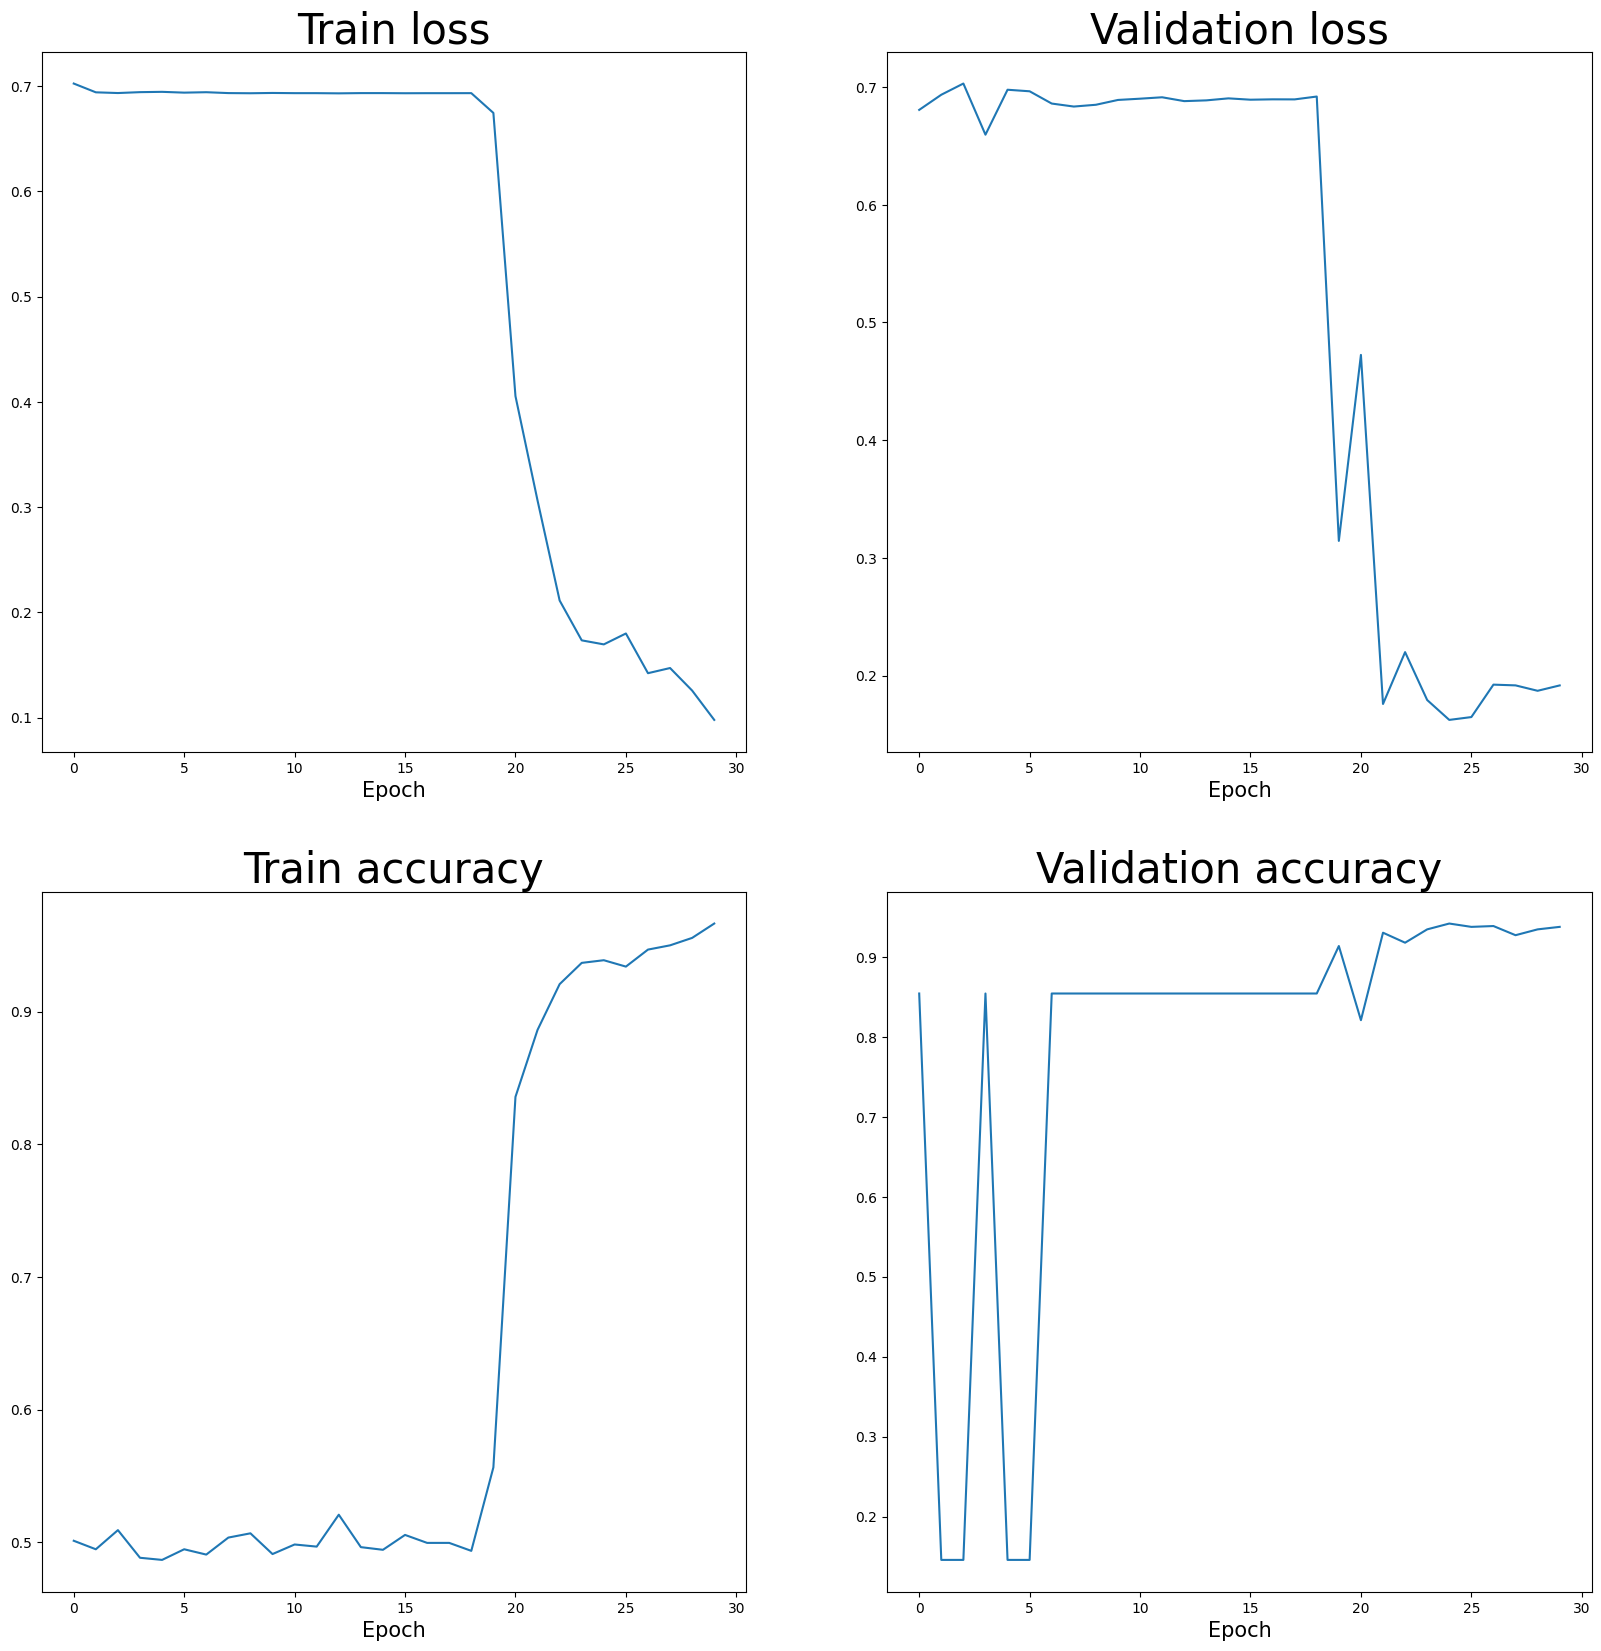

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

axes[0][0].plot(train_l)
axes[0][0].set_title("Train loss", fontsize=30)
axes[0][0].set_xlabel("Epoch", fontsize=15)

axes[0][1].plot(val_l)
axes[0][1].set_title("Validation loss", fontsize=30)
axes[0][1].set_xlabel("Epoch", fontsize=15)

axes[1][0].plot(train_acc)
axes[1][0].set_title("Train accuracy", fontsize=30)
axes[1][0].set_xlabel("Epoch", fontsize=15)

axes[1][1].plot(val_acc)
axes[1][1].set_title("Validation accuracy", fontsize=30)
axes[1][1].set_xlabel("Epoch", fontsize=15)

In [16]:
CHECKPOINTS_DIR = os.path.join("..", "checkpoints")

In [17]:
if not os.path.exists(os.path.join(CHECKPOINTS_DIR, "wav2vec_chkp")):
    os.makedirs(os.path.join(CHECKPOINTS_DIR, "wav2vec_chkp"))

torch.save(
{
    'epoch': 30,
    'model_state_dict': wav2vec.state_dict(),
    # 'optimizer_state_dict': optimizer.state_dict(),
    # 'scheduler_state_dict': scheduler.state_dict(),
    'losses_train': train_l,
    'losses_val': val_l,
},
os.path.join(CHECKPOINTS_DIR, "wav2vec_chkp", "wav2vec" + "_" + "0.75" + "_" + str(val_acc[-1]) + '.pt'),
)